# **MLF Final Project**
### Matyáš Sedláček, Tomáš Marčák

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import RobustScaler

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout 

from keras.optimizers import SGD, Adam, Adamax, SGD, RMSprop
from scipy.signal import decimate
from sklearn.preprocessing import RobustScaler, MinMaxScaler

from google.colab import drive 
import os
import re

# Data import

In [2]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

Organizing the 2D data of each *.csv file into 3D matrix, where each "slice" along the x-axis represents one measurement. 

In [3]:
drive.mount('/content/drive')

#trainCSVlist = sorted_alphanumeric(os.listdir('/content/drive/MyDrive/MLFfinal/Train/CSV'))
#testCSVlist = sorted_alphanumeric(os.listdir('/content/drive/MyDrive/MLFfinal/Test/CSV'))

#trainDF = np.empty((1,45,52))
#testDF = np.empty((1,45,52))

#for trainFile in trainCSVlist:
#            trainDFtemp = np.genfromtxt('/content/drive/MyDrive/MLFfinal/Train/CSV/' + trainFile, delimiter=",", dtype=float)
#            trainDFtemp = trainDFtemp.reshape((1, trainDFtemp.shape[0], trainDFtemp.shape[1]))
#            trainDF = np.concatenate([trainDF,trainDFtemp], axis=0)

#for testFile in testCSVlist:
#            testDFtemp = np.genfromtxt('/content/drive/MyDrive/MLFfinal/Test/CSV/' + testFile, delimiter=",", dtype=float)
#            testDFtemp = testDFtemp.reshape((1, testDFtemp.shape[0],testDFtemp.shape[1]))
#            testDF = np.concatenate([testDF,testDFtemp], axis=0)

#example = np.genfromtxt('/content/drive/MyDrive/MLFfinal/Train/CSV/img_3256.csv', delimiter=',')

#plt.imshow(example)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The formed Numpy 3D arrays are saved in a compressed format, so that we don't have to start all over each time we run the code

In [4]:
# save to google drive in a compressed format

#np.savez_compressed('/content/drive/MyDrive/MLFfinal/Test/extractedTestcomp.npz',testDF)
#np.savez_compressed('/content/drive/MyDrive/MLFfinal/Train/extractedTraincomp.npz',trainDF)

Load the compressed data from drive and store in raw form for further processing.

In [5]:
# load from drive

x_test_raw = np.load('/content/drive/MyDrive/MLFfinal/Test/extractedTestcomp.npz')
x_train_raw = np.load('/content/drive/MyDrive/MLFfinal/Train/extractedTraincomp.npz')
x_test_raw = x_test_raw['arr_0']
x_train_raw = x_train_raw['arr_0']

y_train_raw = pd.read_csv('/content/drive/MyDrive/MLFfinal/y_train.csv')

# Examination

First we look for NaN values

In [6]:
x_train_raw[0,:,:]
NaNs = np.argwhere(np.isnan(x_train_raw))
# we see NaNs as the first element of each slice, then we see, that first slice is all zeros, we also found other NaNs, but only in the first row of each slice
print(x_train_raw)
print(NaNs)

# for demonstrating the random NaNs in the first row
x_train_NaN = x_train_raw[1:, :, 1:] 
randomNaNs = np.argwhere(np.isnan(x_train_NaN))
print(x_train_NaN)
print(randomNaNs)

[[[6.91361572e-310 6.91361572e-310 6.97254530e-316 ... 5.72938864e-313
   6.91325009e-310 6.91329654e-310]
  [0.00000000e+000 6.91329224e-310 4.03179200e-313 ... 6.91329224e-310
   6.91329224e-310 6.91329224e-310]
  [6.91329222e-310 6.91329222e-310 6.91329224e-310 ... 6.91329224e-310
   6.91329222e-310 6.91329224e-310]
  ...
  [6.91329231e-310 6.91329231e-310 6.91329231e-310 ... 6.91329231e-310
   6.91329231e-310 6.91329230e-310]
  [6.91329231e-310 6.91329231e-310 6.91329231e-310 ... 6.91329231e-310
   6.91329231e-310 6.91329231e-310]
  [6.91329231e-310 6.91329231e-310 6.91329231e-310 ... 6.91329231e-310
   6.91329231e-310 6.91329231e-310]]

 [[            nan 3.81570000e+001 5.24250000e+001 ... 2.15880000e+001
   3.47170000e+001 6.56760000e+001]
  [0.00000000e+000 4.08090000e+001 2.57510000e+001 ... 1.04780000e+002
   5.14860000e+001 7.38660000e+000]
  [1.00000000e+000 3.57940000e+001 2.45600000e+001 ... 7.93660000e+001
   5.66940000e+001 6.31450000e+001]
  ...
  [4.10000000e+001 6.24

Second, we identify the labels and their distribution

In [7]:
y_train_raw['target'].value_counts() #class imbalance

1    3746
3    2326
2    2207
Name: target, dtype: int64

# Preprocessing

Removing the identified NaN values, the most practical approach is to discard the first row in each 2D measurement data array, that way we can preserve as large a number of data to train the model on as is possible.

In [8]:
# removing empty slice and index column, as well as first row, since it contains NaN values, from x_train and test data

x_train = x_train_raw[1:, 1:, 1:]
x_test = x_test_raw[1:, 1:, 1:]

We remove the obsolete id column from the label data, and we shift the values to range from 0 to 2 rather than 1 to 3. 

In [9]:
# remove id column from y_train, shift values by 1

y_train = y_train_raw.drop(columns='id')
y_train = y_train-1

Checking if all NaN values were removed.

In [10]:
print(np.argwhere(np.isnan(x_train)),np.argwhere(np.isnan(x_test))) #no NaNs left

[] []


Looking at the properties of measured data, seeing as the range of values is so large and the mean and median rather far apart, it will be necessary to examine the data in more detail.

In [11]:
print(f'Maximum:{x_train.max()}, Minimum: {x_train.min()}, Mean: {x_train.mean()}, Median: {np.median(x_train)}')
print(np.where(x_train == x_train.max()))

Maximum:43007.0, Minimum: 0.017239, Mean: 103.46863690023464, Median: 68.243
(array([3256]), array([21]), array([21]))


## **Trim and scale**

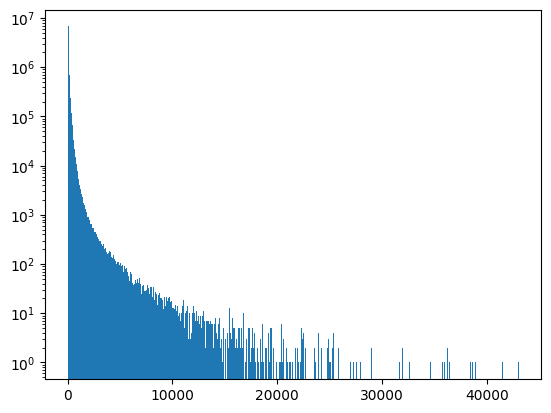

Percentage of values below 9000: 99.99046725828875 %


In [12]:
x_train_undim = np.reshape(x_train, (1,18578076))

plt.figure()
plt.yscale('log')
plt.hist(x_train_undim.flatten(), bins=1000)

plt.show()

print(f'Percentage of values below 9000: {len(np.where(x_train <= 9000)[0])/x_train.size*100} %')

Most of the data is below 9000 in value (99.99 %), we should reduce the impact that outliers will have on model performance. We will do this by basically capping the allowed values (we chose 15000 after several tryouts) and redistributing them randomly into the other high range values, so that we don't skew the data towards an overly represented single high value. 

736 316


(array([73., 57., 67., 74., 78., 80., 62., 90., 86., 69.]),
 array([11000.52995426, 11200.29607932, 11400.06220437, 11599.82832943,
        11799.59445449, 11999.36057954, 12199.1267046 , 12398.89282966,
        12598.65895471, 12798.42507977, 12998.19120483]),
 <BarContainer object of 10 artists>)

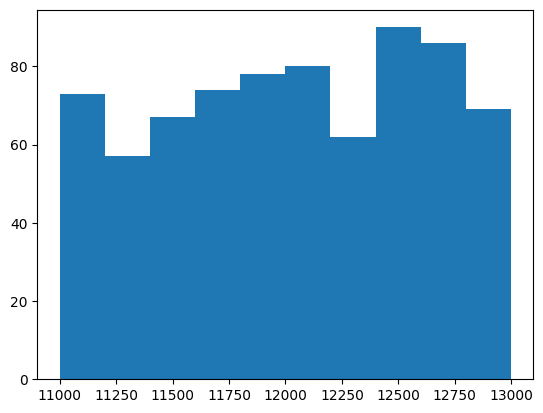

In [13]:
#x_train[x_train >= 13000] = np.random.randint(12000,13000)
#x_test[x_test >= 13000] = np.random.randint(12000,13000)

trainOutliers = len(np.where(x_train >= 13000)[0])
testOutliers = len(np.where(x_test >= 13000)[0])
                   
trainReplacements = np.random.uniform(11000,13000,(trainOutliers,))
testReplacements = np.random.uniform(11000,13000,(testOutliers,))
x_train[x_train >= 13000] = trainReplacements
x_test[x_test >= 13000] = testReplacements

print(trainOutliers, testOutliers)
plt.figure()
plt.hist(trainReplacements)

Visualise capped data 

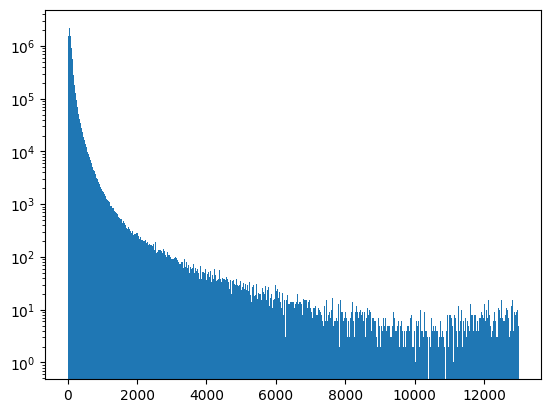

100.0


In [14]:
x_train_undim = np.reshape(x_train, (1,18578076))

plt.figure()
plt.yscale('log')
plt.hist(x_train_undim.flatten(), bins=1000)

plt.show()

print(len(np.where(x_train <= 15000)[0])/x_train.size*100)

Apply scaler, since we still have outliers, we apply a Robust scaler, which is approptiate for this situation

In [15]:
#final preprocesing, scaling
scaler = RobustScaler()

x_trainScaled = np.empty([x_train.shape[0],44*51,1])
for slice in range(x_train.shape[0]):
  x_trainScaled[slice,:,:] = np.reshape(x_train[slice,:,:],[1,44*51,1])
  x_trainScaled[slice,:,:] = scaler.fit_transform(x_trainScaled[slice,:,:])

x_testScaled = np.empty([x_test.shape[0],44*51,1])
for slice in range(x_test.shape[0]):
  x_testScaled[slice,:,:] = np.reshape(x_test[slice,:,:],[1,44*51,1])
  x_testScaled[slice,:,:] = scaler.fit_transform(x_testScaled[slice,:,:])


In [16]:
scaler.center_

array([88.9485])

Visulaising scaled data and scaled data statistics

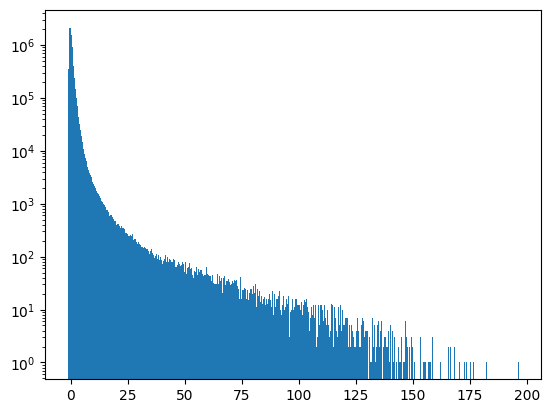

In [17]:
plt.figure()
plt.yscale('log')
plt.hist(x_trainScaled.flatten(), bins=1000)

plt.show()

In [18]:
print(f'Maximum:{x_trainScaled.max()}, Minimum: {x_trainScaled.min()}, Mean: {x_trainScaled.mean()}, Median: {np.median(x_trainScaled)}')

Maximum:196.31616415410386, Minimum: -1.358457483311498, Mean: 0.35423212530735304, Median: 0.0


In [19]:
len(np.where(x_trainScaled <= 120)[0])/x_trainScaled.size*100

99.99731403833206

### **Reduce extra dimensions**

In [20]:
x_trainScaled = np.squeeze(x_trainScaled)
x_testScaled = np.squeeze(x_testScaled)

y_train = y_train.to_numpy()
y_train = np.squeeze(y_train)


**undersample largest class, one-hot encoding of labels**

In [21]:
class0ind = np.where(y_train==0)[0]
class0indDec = np.random.choice(class0ind, 1500, replace=False) # 1500 unique indices

x_trainScaled = np.delete(x_trainScaled, class0indDec, axis=0)
y_trainDec = np.delete(y_train, class0indDec, axis=0)

y_trainEncoded = to_categorical(y_trainDec, num_classes = 3)

### **Check data**

In [22]:
np.unique(y_trainDec, return_counts = True)

(array([0, 1, 2]), array([2246, 2207, 2326]))

# Building the model

In [23]:
model = Sequential()
#model = Sequential()
#model.add(Flatten(input_shape=(2244,)))      
#model.add(Dense(2244, activation='gelu'))
#model.add(Dropout(0.2))
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(16, activation='gelu'))
#model.add(Dense(3, activation='softmax'))


#model.add(Flatten(input_shape=(2244,))) 
#model.add(Dense(3072, activation='gelu')) 
#model.add(Dense(2244, activation='gelu'))
#model.add(Dense(128, activation='gelu')) 
#model.add(Dense(3, activation='softmax'))

model.add(Flatten(input_shape=(2244,)))
model.add(Dense(3072, activation='gelu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='gelu'))
model.add(Dense(64, activation='gelu'))
model.add(Dense(3, activation='softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2244)              0         
                                                                 
 dense (Dense)               (None, 3072)              6896640   
                                                                 
 dropout (Dropout)           (None, 3072)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               393344    
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 7,298,435
Trainable params: 7,298,435
Non-

In [24]:
#optimizer = SGD(learning_rate = 0.01)
#model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

optimizer = Adamax(learning_rate = 0.005, epsilon = 0.2, beta_1=0.9, beta_2=0.999)
#optimizer = SGD(learning_rate = 0.001)
#optimizer = RMSprop(learning_rate = 0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [25]:
history = model.fit(x_trainScaled, y_trainEncoded, epochs=40, batch_size=32, validation_split = 0.2)  

Epoch 1/40
170/170 [==============================] - 3s 8ms/step - loss: 0.5450 - accuracy: 0.7975 - val_loss: 0.2945 - val_accuracy: 0.9004
Epoch 2/40
170/170 [==============================] - 1s 6ms/step - loss: 0.1807 - accuracy: 0.9391 - val_loss: 0.1893 - val_accuracy: 0.9292
Epoch 3/40
170/170 [==============================] - 1s 6ms/step - loss: 0.0982 - accuracy: 0.9707 - val_loss: 0.1644 - val_accuracy: 0.9410
Epoch 4/40
170/170 [==============================] - 1s 6ms/step - loss: 0.0625 - accuracy: 0.9829 - val_loss: 0.1364 - val_accuracy: 0.9513
Epoch 5/40
170/170 [==============================] - 1s 5ms/step - loss: 0.0503 - accuracy: 0.9841 - val_loss: 0.1115 - val_accuracy: 0.9602
Epoch 6/40
170/170 [==============================] - 1s 5ms/step - loss: 0.0292 - accuracy: 0.9919 - val_loss: 0.1266 - val_accuracy: 0.9594
Epoch 7/40
170/170 [==============================] - 1s 5ms/step - loss: 0.0215 - accuracy: 0.9950 - val_loss: 0.1060 - val_accuracy: 0.9646
Epoch 

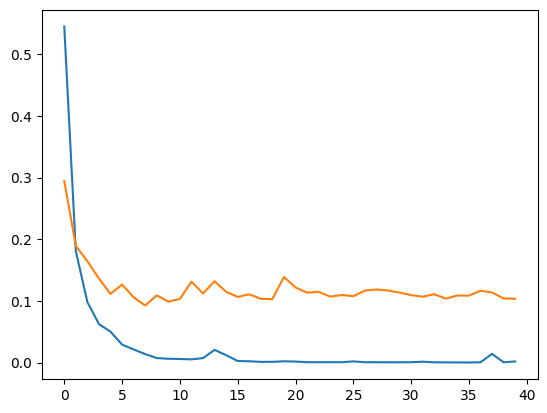

In [26]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

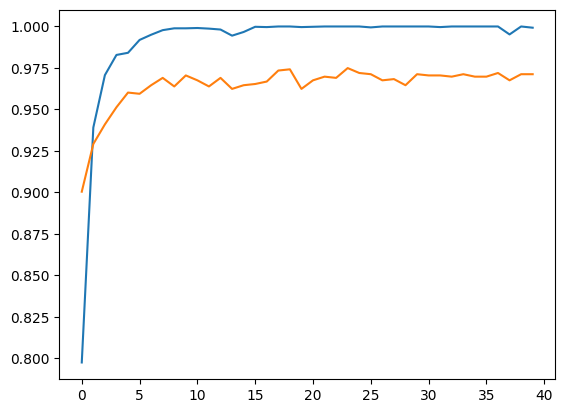

In [27]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [28]:
score = model.evaluate(x_trainScaled, y_trainEncoded, verbose=0)
print('Training loss:', score[0])
print(f'Training accuracy: {score[1]*100} %')

Training loss: 0.02082914300262928
Training accuracy: 99.42469596862793 %


# **Outputing data**

In [29]:
predictions = model.predict(x_testScaled)
predictions = pd.DataFrame(predictions)
predictions = predictions.idxmax(axis=1)+1
predictions = pd.DataFrame(predictions, columns=['target'])
predictions.insert(0,'id',np.arange(len(predictions)))

111/111 [==============================] - 0s 2ms/step


In [31]:
predictions.to_csv('predictions.csv', index=False)